# 파일 설명

* 조석 예보 크롤링 파일  
* 실행은 '실행부' section에서 진행해주시기 바랍니다.  

# API 정보 설명

* 해양수산부 조석 예보 API : http://www.khoa.go.kr/oceangrid/khoa/takepart/openapi/openApiObsTidePreTabDataInfo.do  

* 관측소 정보 : /milsul_Obs.csv

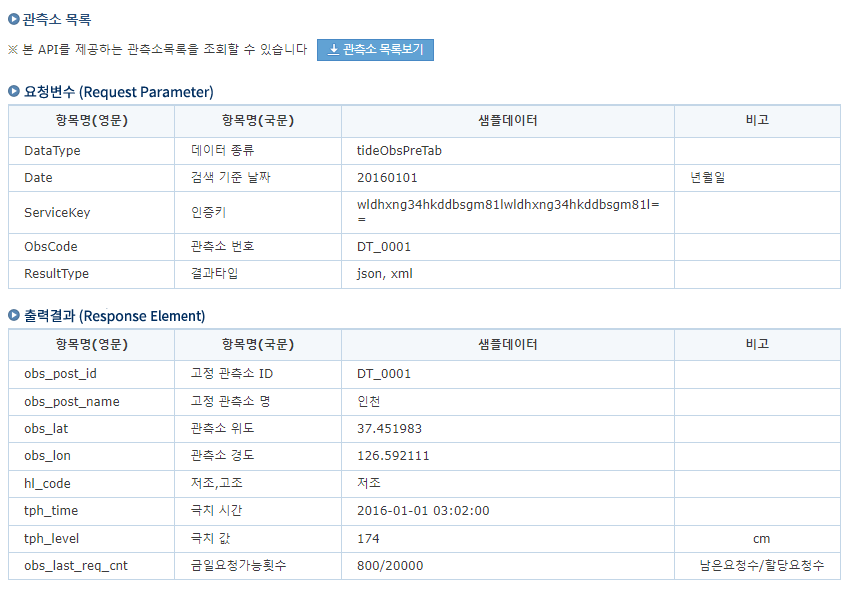

# 기본 import

In [7]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster
from folium import plugins
from folium.features import CustomIcon

# 함수 선언부

In [8]:
# (1) 밀물썰물 json 파일 크롤링 함수
def milsul_crawling(Date, ObsCode, ResultType):

    '''
    * 함수 소개
    기상청 API로부터 기상 예보 불러오기
    반환 데이터 : JSON 파일
    
    * 파라미터 소개
    (1) Date : 검색 기준 날짜 / YYYYMMDD / str
    (2) ObsCode : 관측소 번호 / str
    (3) ResultType : 결과 타입 / json or xml / str
    
    * 주요 키값
    (1) obs_post_id : 고정 관측소 ID
    (2) obs_post_name : 고정 관측소 명
    (3) obs_lat : 관측소 위도
    (4) obs_lon : 관측소 경도
    (5) hl_code : 저조, 고조 구분
    (6) tph_time : 극치 시간
    (7) tph_level : 극치 값 (단위 : cm)
    (8) obs_last_req_cnt : 금일요청가능횟수 (남은요청수/할당요청수)
    
    * 사용 예시
    forecast('20221122', '0200', '60', '127')
    '''
    # 사용할 라이브러리 import
    import requests
    import json
    
    # 기본 정보 변수에 할당
    DataType = 'tideObsPreTab'
    ServiceKey = 'ir2MEaj6OM7hzsVQmxWiTQ=='
    ObsCode = ObsCode
    
    # 크롤링에 필요한 url과 파라미터들 정의
    url = str('https://www.khoa.go.kr/api/oceangrid/' + DataType + '/search.do?')
    params = {'DataType' : DataType, 'ServiceKey' : ServiceKey, 'ObsCode' : ObsCode, 'Date' : Date, 'ResultType' : ResultType}
    
    ## 데이터 응답
    response = requests.get(url, params=params)
    
    ## 리턴값 : json 파일
    return response.json()

In [9]:
# (2) 모든 관측소 자료 불러오기 함수

def milsul_crawling_all(date):
    
    # (1)import와 (2)기본 크롤링 함수 사용 위한 파라미터 정의
    import pandas as pd
    ResultType = 'json'
    
    # 관측소 정보 파일 불러오기
    df = pd.read_csv('milsul_Obs.csv', encoding='cp949')
    
    # 알림 메세지
    print("데이터 수집을 시작합니다. 시간이 5분 가량 소요됩니다.")
    pd.set_option('mode.chained_assignment',  None)
    
    # Date에 맞는 밀물 썰물 데이터 받아오기
    for i in range(len(df['관측소 번호'])):
        
        print(f"({i+1}/{len(df['관측소 번호'])+1}) {df['관측소 번호'][i]} {df['관측소 명'][i]} 데이터 수집")
        
        obscode = df['관측소 번호'][i]
        df['Date'][i] = date
        data = milsul_crawling(date, obscode, ResultType).get('result').get('data')
        
        for j in range(4):
            try:
                df['tph_level_' + str(j+1)][i] = data[j].get('tph_level')
                df['tph_time_' + str(j+1)][i] = data[j].get('tph_time')
                df['hl_code_' + str(j+1)][i] = data[j].get('hl_code')
                
            except:
                print('#######', df['관측소 번호'][i], df['관측소 명'][i], '데이터가 없습니다.')
                continue

    return df

# 실행 부

In [10]:
date = input("날짜를 입력해주세요 (YYYYMMDD)")
df = milsul_crawling_all(date)

set1 = df[['관측소 번호', '관측소 명', '위도', '경도', 'Date', 'hl_code_1', 'tph_time_1', 'tph_level_1']]
set2 = df[['관측소 번호', '관측소 명', '위도', '경도', 'Date', 'hl_code_2', 'tph_time_2', 'tph_level_2']]
set3 = df[['관측소 번호', '관측소 명', '위도', '경도', 'Date', 'hl_code_3', 'tph_time_3', 'tph_level_3']]

set1.columns = ['관측소 번호', '관측소 명', '위도', '경도', 'Date', 'tph_level', 'tph_time', 'hl_code']
set2.columns = ['관측소 번호', '관측소 명', '위도', '경도', 'Date', 'tph_level', 'tph_time', 'hl_code']
set3.columns = ['관측소 번호', '관측소 명', '위도', '경도', 'Date', 'tph_level', 'tph_time', 'hl_code']

df2 = pd.concat([pd.concat([set1, set2], axis=0), set3], axis=0)

날짜를 입력해주세요 (YYYYMMDD) 20221201


데이터 수집을 시작합니다. 시간이 5분 가량 소요됩니다.
(1/145) SO_0732 남애항 데이터 수집
(2/145) SO_0733 강릉항 데이터 수집
(3/145) SO_0734 궁촌항 데이터 수집
(4/145) SO_0735 죽변항 데이터 수집
####### SO_0735 죽변항 데이터가 없습니다.
(5/145) SO_0736 축산항 데이터 수집
####### SO_0736 축산항 데이터가 없습니다.
####### SO_0736 축산항 데이터가 없습니다.
(6/145) SO_0737 강구항 데이터 수집
(7/145) SO_0555 서망항 데이터 수집
####### SO_0555 서망항 데이터가 없습니다.
(8/145) SO_0739 도장항 데이터 수집
(9/145) SO_0740 보옥항 데이터 수집
####### SO_0740 보옥항 데이터가 없습니다.
(10/145) SO_0699 천리포항 데이터 수집
(11/145) SO_0562 승봉도 데이터 수집
(12/145) SO_0573 양포항 데이터 수집
####### SO_0573 양포항 데이터가 없습니다.
####### SO_0573 양포항 데이터가 없습니다.
(13/145) SO_0581 강양항 데이터 수집
(14/145) SO_0571 거제외포 데이터 수집
(15/145) SO_0578 소매물도 데이터 수집
(16/145) SO_0567 쉬미항 데이터 수집
(17/145) SO_0576 화봉리 데이터 수집
(18/145) SO_0564 국화도 데이터 수집
(19/145) SO_0563 울도 데이터 수집
(20/145) SO_0706 청산도 데이터 수집
(21/145) SO_0708 안도항 데이터 수집
(22/145) SO_0712 능양항 데이터 수집
(23/145) SO_0701 홍도항 데이터 수집
(24/145) SO_0702 진도옥도 데이터 수집
(25/145) SO_0703 땅끝항 데이터 수집
####### SO_0703 땅끝항 데이터가 없습니다.
(26/145) SO_0704 소안항 데이터 수

In [11]:
df2

,관측소 번호,관측소 명,위도,경도,Date,tph_level,tph_time,hl_code
0,SO_0732,남애항,37.944,128.788,20221201,저조,2022-12-01 02:52:00,12
1,SO_0733,강릉항,37.772,128.951,20221201,저조,2022-12-01 03:02:00,11
2,SO_0734,궁촌항,37.327,129.270,20221201,저조,2022-12-01 02:45:00,11
3,SO_0735,죽변항,37.054,129.423,20221201,저조,2022-12-01 03:12:00,10
4,SO_0736,축산항,36.509,129.448,20221201,고조,2022-12-01 08:10:00,20
...,...,...,...,...,...,...,...,...
139,SO_1263,구시포항,35.447,126.425,20221201,NaN,NaN,NaN
140,SO_1264,계마항,35.390,126.401,20221201,NaN,NaN,NaN
141,SO_1265,송이도,35.271,126.150,20221201,NaN,NaN,NaN
142,SO_1266,남열항,34.576,127.480,20221201,NaN,NaN,NaN


dddd dddd


'dddd'